# Food Safety and Community Food Production

An exploration of how narratives of "safety" in land use policy impact urban agriculture in select CA Counties: LA, Ventura, Sonoma, Mendocino, and Lake Counties

## The Data

112 total general plans from the five CA Counties (LA, Ventura, Sonoma, Mendocino, Lake)


1. Basic word counts:

2. Modified/precision topic modeling: How often do mentions of food, agriculture, soil health, food safety feature in plans? And as important, where are they mentioned?

In [73]:
# libraries: basic data processing and mapping
import pandas as pd
import geopandas as gpd
import numpy as np

# visualizations
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sn

# set display
pd.options.display.max_columns = 150
pd.options.display.max_rows = 300

In [127]:
# libraries: natural language processing
import os

# extract text
from pdfminer.high_level import extract_text
import re

# stop words; split sentences; stems
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer

# topic modeling
import gensim
import pyLDAvis
import pyLDAvis.gensim_models

#### The Plan Elements

General Plans are the long-range planning document that guides city-planning decisions in municipalities. California requires these plans to include some basic "elements", including but not limited to land use, circulation, housing, open space, recreation, and conservation. Every effort was made to include the most recently adopted, full versions of the General Plan for each city. However, despite the key role they play in long-range city-planning, General Plans are not generally stored in any kind of publicly accessible directory, and therefore they must be located and downloaded individually for each city. Moreover, there is no standard format that cities have chosen to make their General Plans available to the public. Almost all are saved as PDFs, and only some are available as a single organized document. Half as often, the plans were stored as separate elements, with some cities providing no "table of contents" to inform readers about the intended organization of the separate plan elements. In those cases, by default, I organized these plan elements based on a common format that was noticeable in most plans: land use, housing, economic development, open space, recreation, conservation, safety, and noise. A fifth of them were scanned documents that had to be converted into searchable PDFs.

Getting the PDFs into one file containing all the General Plans involved two steps. Most whole documents were downloaded directly into the Github repository. However, both individual plan elements and some of the whole plans that were too large in size to download directly to the repository -- due to upload size maximums -- and had to be split and uploaded into a separate plan sections subfolder and subsequently remerged using Python (see "Prepping Plans" notebook).

NOTE: In lieu of a single Land Use Element in its General Plan, the City of Los Angeles has 35 different Community Land Use Plans that each cover a collection of neighborhoods within the City. Without more time to understand how the boundaries for these 35 communities were formed or whether they correspond to/align neatly with any formal jurisdictional lines (e.g. neighborhoods, districts, etc.) I was reluctant to include them in the analysis.

NOTE: Gardena and Lakewood were excluded from this analysis because the General Plan for Gardena was not readable/would not upload properly. Despite efforts to locate the plan for Lakewood (including inquiries to the City), the plan was not accessible.

In [3]:
# loading plans
planlistA = os.listdir('C:/Users/melod/Documents/data science/Food-Systems-Policy-Research/Food Systems and General Plans/General Plans A')
planlistA

['.ipynb_checkpoints',
 'Agoura Hills.pdf',
 'Alhambra.pdf',
 'Arcadia.pdf',
 'Artesia.pdf',
 'Avalon.pdf',
 'Azusa.pdf',
 'Baldwin Park.pdf',
 'Bell Gardens.pdf',
 'Bell.pdf',
 'Bellflower.pdf',
 'Beverly Hills.pdf',
 'Bradbury.pdf',
 'Burbank.pdf',
 'Calabasas.pdf',
 'Camarillo.pdf',
 'Carson.pdf',
 'Cerritos.pdf',
 'Claremont.pdf',
 'Clearlake.pdf',
 'Commerce.PDF',
 'Compton.pdf',
 'Cotati.pdf',
 'Covina.pdf',
 'Cudahy.pdf',
 'Culver City.pdf',
 'Diamond Bar.pdf',
 'Downey.pdf',
 'Duarte.pdf',
 'El Monte.pdf',
 'El Segundo.pdf',
 'Filmore.pdf',
 'Fort Bragg.pdf',
 'Glendale.pdf',
 'Hawaiian Gardens.pdf',
 'Hawthorne.pdf',
 'Healdsburg.pdf',
 'Hermosa Beach.pdf',
 'Hidden Hills.pdf',
 'Huntington Park.pdf',
 'Industry.pdf',
 'Inglewood.pdf',
 'Irwindale.pdf',
 'La Canada Flintridge.pdf',
 'La Habra Heights.pdf',
 'La Mirada.pdf',
 'La Puente.pdf',
 'La Verne.pdf',
 'Lakeport.pdf',
 'Lancaster.pdf',
 'Lawndale.pdf',
 'Lomita.pdf',
 'Long Beach.pdf',
 'Lynwood.pdf',
 'Malibu.pdf',
 'M

In [4]:
# loading plans
planlistB = os.listdir('C:/Users/melod/Documents/data science/Food-Systems-Policy-Research/Food Systems and General Plans/General Plans B')
planlistB

['.ipynb_checkpoints',
 'Point Arena.pdf',
 'Port Hueneme.pdf',
 'Rancho Palos Verdes.pdf',
 'Redondo Beach.pdf',
 'Rohnert Park.pdf',
 'Rolling Hills Estates.pdf',
 'Rolling Hills.pdf',
 'Rosemead.pdf',
 'San Dimas.pdf',
 'San Fernando.pdf',
 'San Gabriel.pdf',
 'San Marino.pdf',
 'Santa Clarita.pdf',
 'Santa Fe Springs.pdf',
 'Santa Monica.pdf',
 'Santa Paula.pdf',
 'Santa Rosa.pdf',
 'Sebastopol.pdf',
 'Sierra Madre.pdf',
 'Signal Hill.pdf',
 'Simi Valley.pdf',
 'Sonoma.pdf',
 'South El Monte.pdf',
 'South Gate.pdf',
 'South Pasadena.pdf',
 'Temple City.pdf',
 'Thousand Oaks.pdf',
 'Torrance.pdf',
 'Ukiah.pdf',
 'Ventura.pdf',
 'Vernon.pdf',
 'West Covina.pdf',
 'West Hollywood.pdf',
 'Westlake Village.pdf',
 'Whittier.pdf',
 'Willits.pdf',
 'Windsor.pdf']

In [6]:
# function: extracting text froms plans in folder A
def readPDF(planname):
    txt = extract_text('C:/Users/melod/Documents/data science/Food-Systems-Policy-Research/Food Systems and General Plans/General Plans A/'+planname)
    
    # remove punctuation, numbers, etc.
    txt = re.sub(r"[^A-z\s]", "", txt)
    # remove whitepace
    txt = re.sub(r"\s+", " ", txt) 
    
    # cleaning up name
    planname = planname.split(".")[0]
    
    # insert muni(planname) to the beginning of plan: creating indexable muni ID within each plan string
    txt = planname+", "+txt
    
    print('Finished {}'.format(planname))
    return txt

# read in all pdf files
suffixes = ('.pdf', '.PDF')
genplanA = [readPDF(pn) for pn in planlistA if pn.endswith(suffixes)]

Finished Agoura Hills
Finished Alhambra
Finished Arcadia
Finished Artesia
Finished Avalon
Finished Azusa
Finished Baldwin Park
Finished Bell Gardens
Finished Bell
Finished Bellflower
Finished Beverly Hills
Finished Bradbury
Finished Burbank
Finished Calabasas
Finished Camarillo
Finished Carson
Finished Cerritos
Finished Claremont
Finished Clearlake
Finished Commerce
Finished Compton
Finished Cotati
Finished Covina
Finished Cudahy
Finished Culver City
Finished Diamond Bar
Finished Downey
Finished Duarte
Finished El Monte
Finished El Segundo
Finished Filmore
Finished Fort Bragg
Finished Glendale
Finished Hawaiian Gardens
Finished Hawthorne
Finished Healdsburg
Finished Hermosa Beach
Finished Hidden Hills
Finished Huntington Park
Finished Industry
Finished Inglewood
Finished Irwindale
Finished La Canada Flintridge
Finished La Habra Heights
Finished La Mirada
Finished La Puente
Finished La Verne
Finished Lakeport
Finished Lancaster
Finished Lawndale
Finished Lomita
Finished Long Beach
Finis

In [5]:
# function: extracting text froms plans in folder B
def readPDF(planname):
    txt = extract_text('C:/Users/melod/Documents/data science/Food-Systems-Policy-Research/Food Systems and General Plans/General Plans B/'+planname)
    
    # remove punctuation, numbers, etc.
    txt = re.sub(r"[^A-z\s]", "", txt)
    # remove whitepace
    txt = re.sub(r"\s+", " ", txt) 
    
    # cleaning up name
    planname = planname.split(".")[0]
    
    # insert muni(planname) to the beginning of plan: creating indexable muni ID within each plan string
    txt = planname+", "+txt
    
    print('Finished {}'.format(planname))
    return txt

# read in all pdf files
suffixes = ('.pdf', '.PDF')
genplanB = [readPDF(pn) for pn in planlistB if pn.endswith(suffixes)]

Finished Point Arena
Finished Port Hueneme
Finished Rancho Palos Verdes
Finished Redondo Beach
Finished Rohnert Park
Finished Rolling Hills Estates
Finished Rolling Hills
Finished Rosemead
Finished San Dimas
Finished San Fernando
Finished San Gabriel
Finished San Marino
Finished Santa Clarita
Finished Santa Fe Springs
Finished Santa Monica
Finished Santa Paula
Finished Santa Rosa
Finished Sebastopol
Finished Sierra Madre
Finished Signal Hill
Finished Simi Valley
Finished Sonoma
Finished South El Monte
Finished South Gate
Finished South Pasadena
Finished Temple City
Finished Thousand Oaks
Finished Torrance
Finished Ukiah
Finished Ventura
Finished Vernon
Finished West Covina
Finished West Hollywood
Finished Westlake Village
Finished Whittier
Finished Willits
Finished Windsor


In [7]:
# appending plan strings list parsed from plans in folder A to the parsed plans in folder B
genplan = genplanA + genplanB

In [8]:
# checking integrity of join
print(len(genplanA))
print(len(genplanB))
print(len(genplan))

69
37
106


In [9]:
# save list of plans to hardrive so that it called be reloaded/called directly instead of
#  having to rerun time and resource intensive scraping function
import pickle

with open('genplan.pickle', 'wb') as f:
    pickle.dump(genplan, f)

In [14]:
# establish list of stopwords to exclude
swords = stopwords.words('english')

### (A) Keyword Counts: Are Cities Even Talking About Food Systems?

This exercise aims to identify basic mentions of a select set of keywords focused on both food production and the environment more generally by locating all unique positions for the keyword mentioned in the raw text. A version of this exercise was also attempted using a cleaned wordlist for each plan, but after comparing the two methods, it appeared that the clean wordlist method resulted in fewer mentions of keywords being picked up (more ommissions).

In [18]:
# saving positions of keywords in cleaned wordlists to a dictionary: all plans

# create empty dictionary to store topic mention counts
keydict1 = {}
# create empty list to store keyword count columns for each city
plan_col = []

keywords = ['food', 'agriculture', 'garden', 'farm', 'fruit', 'vegetable', 'animal', 'soil', 
            'remediation', 'contaminate', 'sustainability', 'climate', 'environment', 
            'health', 'safety', 'justice']

for plan in genplan:
    
    # generating wordlist from plan
    wordlist = [word for word in word_tokenize(plan.lower()) 
                 if word not in swords]
    
    # generate counts
    for key in keywords:
        # identify count of each mention of keyword and save to a dictionary
        keydict1[key] = wordlist.count(key) 

    # turn dicts into dfs
    keywordsc = pd.DataFrame.from_dict(keydict1, orient='index', columns=[plan.split(", ")[0]]) # muni plan name as series name
    
    # add each municipality column generated to a single dataframe
    plan_col.append(keywordsc)
    munikeys1 = pd.concat(plan_col, axis = 1)

# inspect/show
munikeys1

,Agoura Hills,Alhambra,Arcadia,Artesia,Avalon,Azusa,Baldwin Park,Bell Gardens,Bell,Bellflower,Beverly Hills,Bradbury,Burbank,Calabasas,Camarillo,Carson,Cerritos,Claremont,Clearlake,Commerce,Compton,Cotati,Covina,Cudahy,Culver City,Diamond Bar,Downey,Duarte,El Monte,El Segundo,Filmore,Fort Bragg,Glendale,Hawaiian Gardens,Hawthorne,Healdsburg,Hermosa Beach,Hidden Hills,Huntington Park,Industry,Inglewood,Irwindale,La Canada Flintridge,La Habra Heights,La Mirada,La Puente,La Verne,Lakeport,Lancaster,Lawndale,Lomita,Long Beach,Lynwood,Malibu,Manhattan Beach,Maywood,Monrovia,Montebello,Monterey Park,Moorpark,Norwalk,Ojai,Oxnard,Palmdale,Palos Verdes,Paramount,Pasadena,Petaluma,Pico Rivera,Point Arena,Port Hueneme,Rancho Palos Verdes,Redondo Beach,Rohnert Park,Rolling Hills Estates,Rolling Hills,Rosemead,San Dimas,San Fernando,San Gabriel,San Marino,Santa Clarita,Santa Fe Springs,Santa Monica,Santa Paula,Santa Rosa,Sebastopol,Sierra Madre,Signal Hill,Simi Valley,Sonoma,South El Monte,South Gate,South Pasadena,Temple City,Thousand Oaks,Torrance,Ukiah,Ventura,Vernon,West Covina,West Hollywood,Westlake Village,Whittier,Willits,Windsor
food,2,10,16,13,14,9,63,10,6,17,38,6,9,7,20,40,4,5,8,0,30,51,8,2,3,34,12,3,113,7,1,4,26,4,100,2,20,2,1,0,66,7,8,1,0,5,7,20,0,10,8,54,14,2,1,5,46,15,39,25,4,6,7,21,3,0,24,10,26,13,19,15,26,5,14,4,1,12,0,5,3,18,57,28,6,11,59,10,13,33,1,48,39,10,17,30,19,47,6,6,36,6,6,0,4,8
agriculture,0,1,2,6,4,5,16,5,4,10,4,20,7,2,81,11,6,8,5,1,8,12,9,7,4,8,5,10,10,4,24,7,5,2,7,8,3,2,3,0,6,3,8,1,1,6,5,11,4,9,22,20,1,8,2,5,4,7,7,56,4,21,40,12,1,0,9,16,3,33,4,10,2,10,8,1,1,5,1,0,1,24,10,3,36,16,18,1,14,5,25,4,3,2,1,6,10,74,28,1,4,2,2,0,3,19
garden,0,9,15,1,9,2,26,1,6,4,9,2,1,0,4,4,2,18,0,0,10,3,0,0,5,1,1,2,6,0,0,1,18,1,5,2,5,0,1,1,4,1,2,0,0,9,0,2,0,9,2,23,0,0,3,1,2,1,0,0,0,0,0,7,0,0,29,2,3,0,0,3,4,3,14,0,0,4,0,9,3,5,16,35,2,1,3,12,4,4,3,6,2,6,0,6,6,3,1,0,7,3,0,0,0,0
farm,2,1,10,7,2,0,5,4,9,10,6,9,2,0,130,7,12,0,0,4,11,4,3,0,10,8,10,3,21,1,11,1,5,2,1,1,0,11,4,1,7,7,5,6,0,0,10,7,2,5,1,5,0,0,8,2,5,6,0,2,9,23,0,9,9,0,2,2,8,6,0,2,0,25,2,0,0,5,0,0,2,7,2,0,15,6,10,3,8,7,0,10,0,16,0,15,5,25,5,1,8,0,1,0,5,9
fruit,0,0,0,0,0,0,5,0,0,0,2,1,0,0,20,0,0,1,0,0,0,1,0,0,0,0,0,0,5,0,1,0,1,0,1,1,1,0,0,0,1,0,3,0,0,1,4,1,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,2,0,0,0,0,0,0,0,4,0,1,1,0,0,0,0,0,0,0
vegetable,0,1,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0
animal,4,1,1,3,9,1,1,3,3,11,6,17,6,7,13,17,7,8,4,2,3,2,13,0,2,4,1,4,1,0,2,3,16,2,0,1,3,2,4,0,0,2,3,11,1,1,2,8,1,1,4,5,2,29,0,0,2,7,1,8,1,4,5,12,0,2,8,9,1,22,4,23,0,4,5,10,0,2,2,0,1,14,0,9,5,8,6,10,5,7,0,0,2,1,0,32,3,2,0,3,1,0,6,0,0,3
soil,17,16,8,10,18,5,12,14,11,11,37,49,8,18,48,40,9,16,5,6,15,6,64,9,26,20,12,5,24,12,10,8,35,14,11,2,12,8,12,0,20,10,14,9,4,9,3,27,14,14,20,46,30,8,7,1,14,22,8,27,0,25,17,29,10,0,11,21,10,28,1,27,6,25,20,32,13,9,4,1,3,59,9,10,4,17,16,21,42,9,2,16,2,7,3,85,5,11,8,10,6,4,8,0,23,12
remediation,1,1,0,0,1,0,0,5,2,3,2,0,1,0,23,20,1,0,1,1,1,0,10,1,1,2,0,5,7,3,0,0,19,2,6,0,0,0,0,0,3,2,1,6,0,6,0,0,0,3,1,4,0,2,2,1,1,3,5,0,0,1,2,0,0,2,4,1,3,2,2,0,3,0,1,0,3,0,0,1,1,12,15,1,1,2,0,0,50,2,0,4,0,1,3,0,2,0,6,4,1,0,0,0,0,4
contaminate,1,0,0,1,0,0,0,0,0,0,0,1,1,1,2,0,0,2,0,0,0,1,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,2,0,0,0,0,2


In [23]:
# reorienting table the keyword counts so they can be joined to other gdfs
munikeyst1 = munikeys1.transpose()

# naming index column
munikeyst1.index.name = "City"

# saving keyword counts table
munikeyst1.to_csv("Plan_Keyword_Counts_list.csv")

In [19]:
# saving positions of keywords in raw plan text to a dictionary: all plans
textdictall = {}
plan_cols = []

keywords = ['food', 'agriculture', 'garden', 'farm', 'fruit', 'vegetable', 'animal', 'soil', 
            'remediation', 'contaminate', 'sustainability', 'climate', 'environment', 
            'health', 'safety', 'justice']

for plan in genplan:
    for key in keywords:
        # identify text positions of keyword mentions
        textpositionsall = [i for i in range(len(plan)) if plan.startswith(key, i)] # adapted: https://www.geeksforgeeks.org/python-all-occurrences-of-substring-in-string/#
        # save list of positions for each keyword in a dictionary
        textdictall[key] = textpositionsall

    textdict = {}

    # generate counts for each keyword by summing the number of positions in its position list
    for keyword in textdictall:
        for position in keyword:
            # store counts in dictionary
            textdict[keyword] = len(textdictall[keyword])

        # turn dicts into dfs
        keywordscount = pd.DataFrame.from_dict(textdict, orient='index', columns=[plan.split(", ")[0]]) # muni plan name as series name
    
    # add each municipality column generated to a single dataframe
    plan_cols.append(keywordscount)
    munikeys = pd.concat(plan_cols, axis = 1)

# inspect/show
munikeys

,Agoura Hills,Alhambra,Arcadia,Artesia,Avalon,Azusa,Baldwin Park,Bell Gardens,Bell,Bellflower,Beverly Hills,Bradbury,Burbank,Calabasas,Camarillo,Carson,Cerritos,Claremont,Clearlake,Commerce,Compton,Cotati,Covina,Cudahy,Culver City,Diamond Bar,Downey,Duarte,El Monte,El Segundo,Filmore,Fort Bragg,Glendale,Hawaiian Gardens,Hawthorne,Healdsburg,Hermosa Beach,Hidden Hills,Huntington Park,Industry,Inglewood,Irwindale,La Canada Flintridge,La Habra Heights,La Mirada,La Puente,La Verne,Lakeport,Lancaster,Lawndale,Lomita,Long Beach,Lynwood,Malibu,Manhattan Beach,Maywood,Monrovia,Montebello,Monterey Park,Moorpark,Norwalk,Ojai,Oxnard,Palmdale,Palos Verdes,Paramount,Pasadena,Petaluma,Pico Rivera,Point Arena,Port Hueneme,Rancho Palos Verdes,Redondo Beach,Rohnert Park,Rolling Hills Estates,Rolling Hills,Rosemead,San Dimas,San Fernando,San Gabriel,San Marino,Santa Clarita,Santa Fe Springs,Santa Monica,Santa Paula,Santa Rosa,Sebastopol,Sierra Madre,Signal Hill,Simi Valley,Sonoma,South El Monte,South Gate,South Pasadena,Temple City,Thousand Oaks,Torrance,Ukiah,Ventura,Vernon,West Covina,West Hollywood,Westlake Village,Whittier,Willits,Windsor
food,2,12,15,15,11,8,81,7,5,16,28,7,7,7,12,39,1,5,9,4,27,48,7,3,3,32,11,2,114,9,1,3,18,2,84,2,19,2,0,0,61,6,5,0,0,5,6,16,0,10,6,63,9,2,1,4,45,11,33,23,4,5,6,21,2,0,24,12,28,14,18,14,24,4,14,5,1,7,0,5,2,17,43,31,6,11,61,8,8,24,1,37,72,10,15,16,16,42,6,4,33,9,6,0,3,8
agriculture,0,1,0,3,1,4,10,4,1,5,3,14,6,1,54,7,4,6,5,1,3,12,8,4,3,5,1,4,7,4,17,2,2,1,2,6,0,1,2,0,2,1,3,0,0,2,1,4,2,3,9,16,1,3,1,3,2,6,4,39,2,15,20,5,1,0,0,8,0,18,2,6,1,5,2,0,0,5,1,0,1,20,6,0,28,6,14,1,7,4,14,2,2,2,1,3,5,28,16,1,1,1,0,0,2,16
garden,0,13,5,5,7,3,49,11,6,4,16,2,4,1,13,17,6,6,3,0,5,15,1,9,5,7,1,3,11,0,0,1,18,1,5,2,11,0,1,0,22,0,5,1,0,4,2,1,0,3,3,69,0,0,3,4,5,0,14,16,0,1,0,6,0,0,47,3,13,3,0,2,5,3,10,2,0,7,0,10,4,12,13,30,6,18,27,14,3,4,5,19,15,8,1,5,8,18,11,0,26,11,0,0,1,1
farm,2,1,14,12,1,5,31,26,7,23,9,23,5,1,220,17,13,3,3,4,12,13,3,1,19,7,4,6,31,8,55,8,10,6,14,7,2,9,3,0,22,12,17,10,1,13,18,29,4,15,14,43,1,0,8,6,12,9,3,17,16,34,5,25,6,1,19,11,11,23,9,6,8,31,24,9,1,9,0,0,5,22,10,13,28,42,22,5,26,20,4,13,12,2,3,22,16,44,22,8,14,1,9,0,5,30
fruit,0,1,0,2,0,1,10,0,0,0,2,4,0,0,24,1,0,1,1,0,4,5,14,1,0,3,0,0,11,0,1,0,1,0,2,1,1,0,0,0,0,0,4,0,0,1,2,1,0,0,2,5,0,0,0,0,0,2,1,1,0,0,0,2,0,0,5,0,0,1,1,1,0,0,1,0,0,0,0,0,0,2,1,5,0,0,6,2,0,0,0,1,5,0,0,5,1,1,1,0,3,1,0,0,0,0
vegetable,0,3,0,2,0,0,5,1,0,0,0,0,0,0,14,1,0,0,1,0,4,5,0,0,0,4,0,0,12,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2,2,1,0,0,0,1,0,2,4,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,4,0,0,6,0,0,0,0,1,4,0,0,0,2,0,0,1,4,1,0,0,0,0
animal,8,1,1,4,10,12,2,5,2,13,4,27,6,9,9,21,5,14,5,3,5,1,14,0,2,8,0,5,4,1,2,4,39,3,1,1,6,3,2,0,0,4,9,14,1,2,5,9,4,1,7,12,2,30,1,1,3,8,2,15,2,6,6,14,2,2,18,12,4,29,5,49,0,5,8,15,0,5,3,0,1,17,0,5,8,16,10,14,11,8,1,0,6,1,1,42,5,2,4,8,4,0,15,0,1,5
soil,17,18,15,12,28,13,17,26,46,17,52,100,16,35,77,56,14,28,11,13,25,14,94,10,67,34,12,15,32,16,18,16,31,24,13,4,23,14,47,0,40,21,35,15,10,22,5,54,21,31,42,64,43,16,7,3,17,29,17,43,0,62,23,67,14,3,22,20,11,56,2,53,11,36,38,71,18,14,6,2,4,88,15,9,8,30,29,35,84,11,2,22,4,10,4,106,10,20,15,13,8,6,20,0,20,18
remediation,1,0,0,0,1,0,0,5,1,3,2,0,1,0,8,17,1,0,1,1,1,0,9,0,1,1,0,5,6,3,0,0,6,0,1,0,0,0,0,0,3,2,1,6,0,6,0,0,0,3,1,4,0,2,2,1,1,3,4,0,0,1,2,0,0,2,4,0,3,2,1,0,3,0,0,0,3,0,0,1,0,11,11,1,1,2,0,0,50,2,0,3,0,1,3,0,1,0,6,2,1,0,0,0,0,3
contaminate,2,0,0,1,0,1,9,1,0,0,3,1,1,1,9,6,1,5,3,3,1,3,9,2,0,5,4,3,5,8,1,0,7,0,2,0,2,0,0,0,10,2,2,0,0,5,0,1,0,3,0,4,2,0,1,2,3,0,2,2,0,0,0,3,0,0,1,1,0,0,1,0,1,5,5,0,4,0,0,1,0,7,22,1,3,2,0,5,4,2,0,1,0,2,0,0,4,1,3,2,2,0,0,0,0,7


In [32]:
# reorienting table the keyword counts so they can be joined to other gdfs
munikeyst = munikeys.transpose()

# naming index column
munikeyst.index.name = "City"

# saving keyword counts table
munikeyst.to_csv("Plan_Keyword_Counts_text.csv")

Now to visualize which cities potentially include community food production in their long-range land use planning  goals and strategies, the keyword count table will be merged with the table including municipal boundaries and preliminary information about the density of urban agriculture sites and facilities that produce toxic waste in a given municipality (created in the "LAC Map" notebook).

In [36]:
# joining keyword counts table to table with geocoded municipalities with preliminary UA site and Toxic Release densities

# loading file
LAC = gpd.read_file('C:/Users/melod/Documents/data science/Food-Systems-Policy-Research/Food Systems and General Plans/LACfinal.geojson')

# set index to 'city' column
LAC.set_index('City', inplace = True)

# joining
LACmunikeys = munikeyst.join(LAC, how= 'left')

# converting to gdf 
LACmunikeys = gpd.GeoDataFrame(LACmunikeys, geometry = "geometry", crs='EPSG:4326')

In [38]:
# inspect/show
#LACmunikeys.head(5)

The following set of choropleth maps show which cities in LA County mention a selection of keywords related to community food production. 

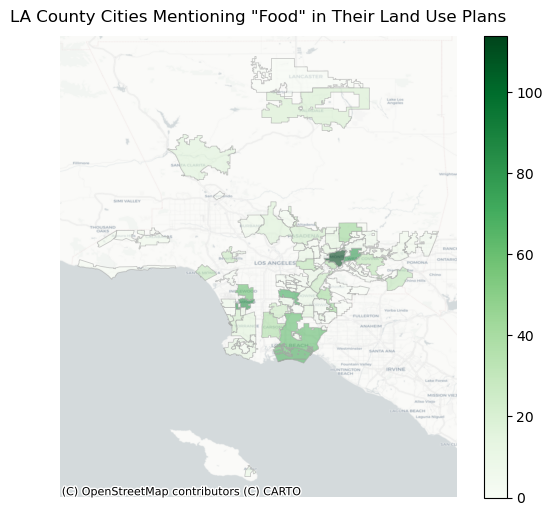

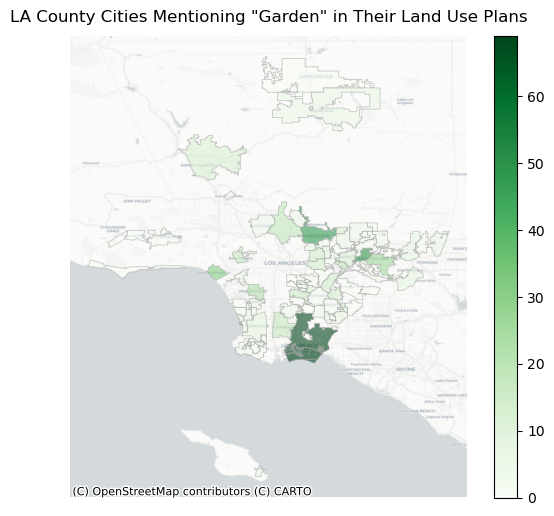

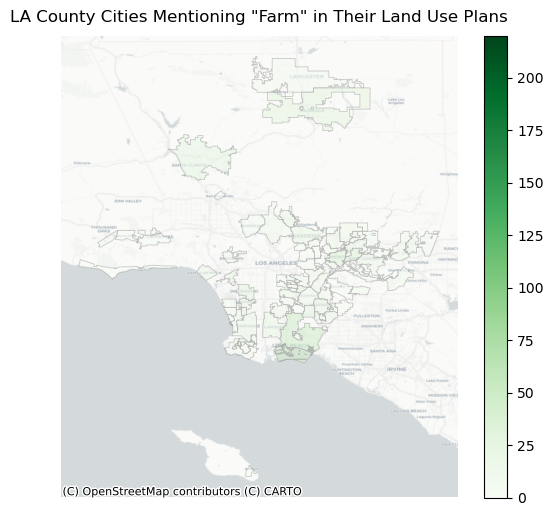

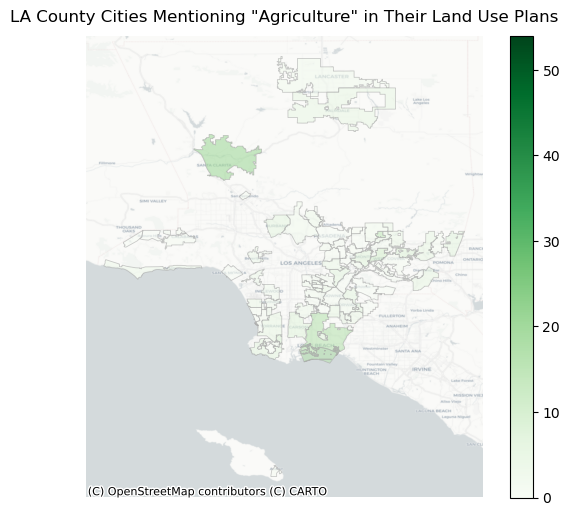

In [128]:
# loop to generate maps for each keyword

keywords = ['food', 'garden', 'farm', 'agriculture']

for key in keywords:
    fig, ax = plt.subplots(figsize =(7,6))
    
    # keyword
    LACmunikeys.plot(ax=ax,
                     column = key,
                     edgecolor = 'darkgrey',
                     linewidth = .6,
                     cmap = 'Greens',
                     alpha = .6,
                     legend = True)
    
    # customizations
    ax.axis('off')
    ax.set_title('LA County Cities Mentioning "{}" in Their Land Use Plans'.format(key.title()), 
                 fontsize=12, pad=10)
    
    # basemap
    ctx.add_basemap(ax, crs = 'EPSG:4326', source=ctx.providers.CartoDB.Positron)

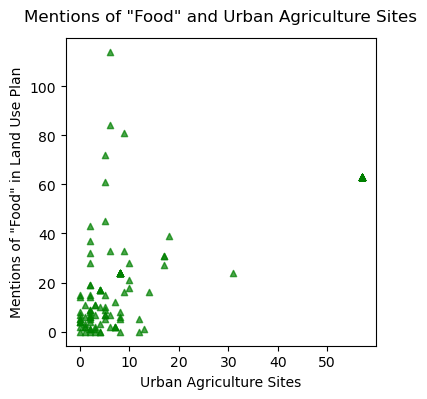

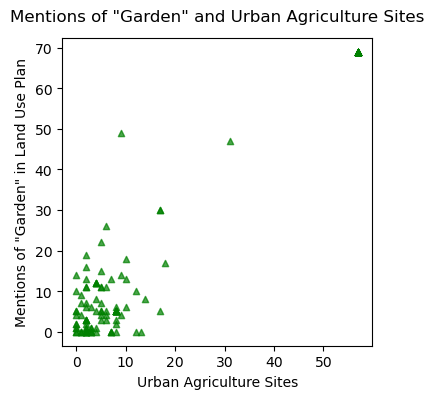

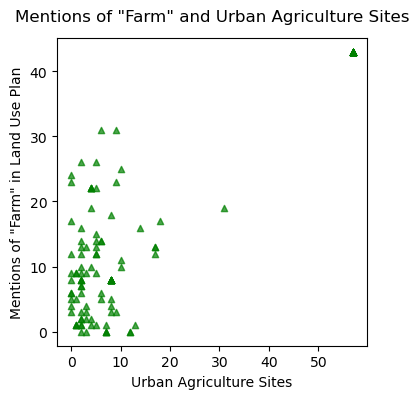

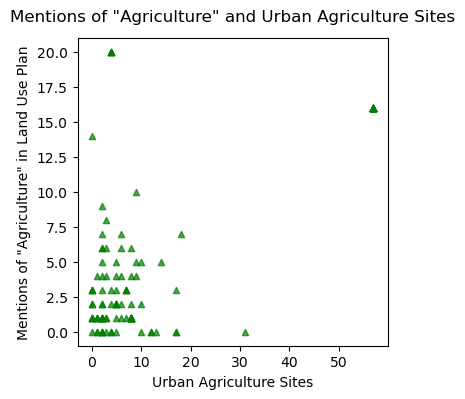

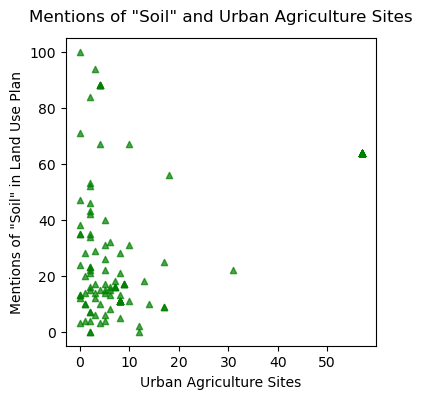

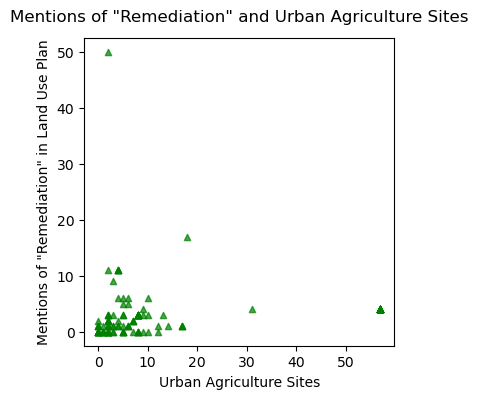

In [64]:
# scatterplots comparing density of urban ag sites and toxic release facilities and discharge totals to frequency of keyword mentions

keywords = ['food', 'garden', 'farm', 'agriculture', 'soil', 'remediation']

for key in keywords:
    fig, ax = plt.subplots(figsize= (4, 4))

    plt.scatter(LACmunikeys['UA Sites'], LACmunikeys[key], marker= '^', s= 20, c= 'green', alpha=0.7)
    
    plt.title('Mentions of "{}" and Urban Agriculture Sites'.format(key.title()), pad= 12)
    plt.xlabel("Urban Agriculture Sites")
    plt.ylabel('Mentions of "{}" in Land Use Plan'.format(key.title()))

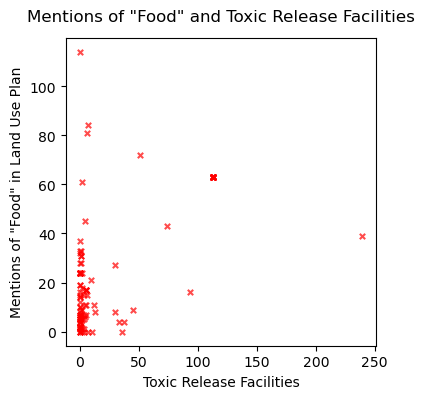

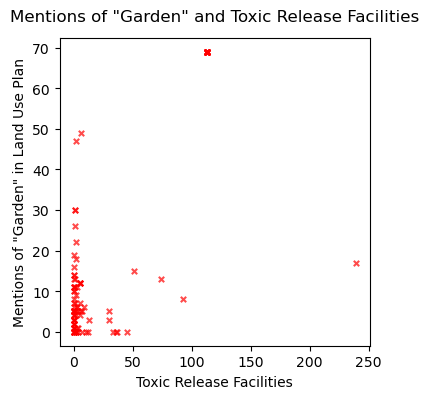

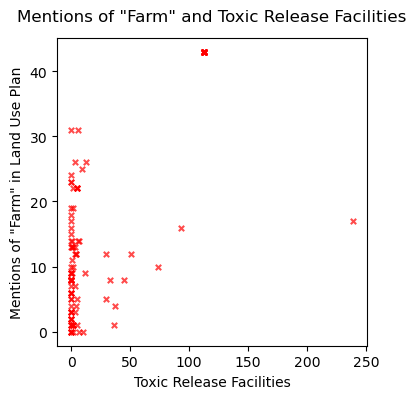

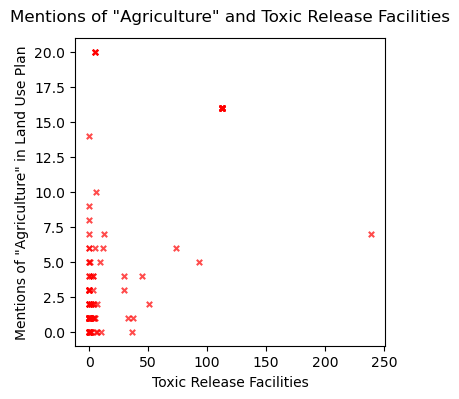

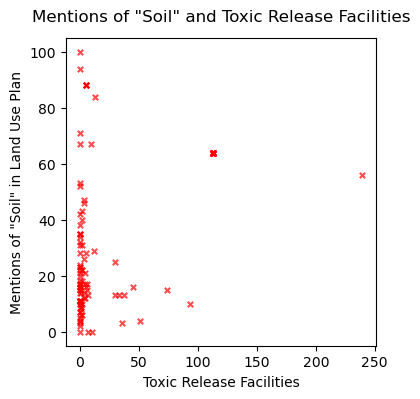

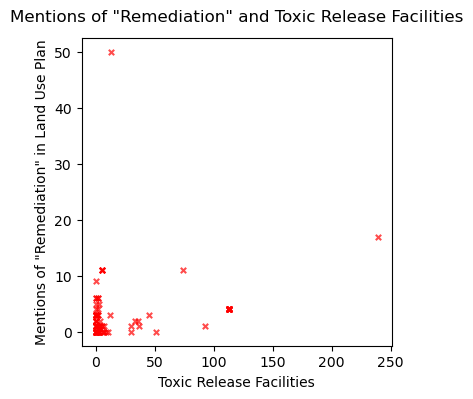

In [63]:
for key in keywords:
    fig, ax = plt.subplots(figsize= (4, 4))

    plt.scatter(LACmunikeys['Facilities'], LACmunikeys[key], marker= 'x', s= 15, c= 'red', alpha=0.7)
    
    plt.title('Mentions of "{}" and Toxic Release Facilities'.format(key.title()), pad= 12)
    plt.xlabel("Toxic Release Facilities")
    plt.ylabel('Mentions of "{}" in Land Use Plan'.format(key.title()))

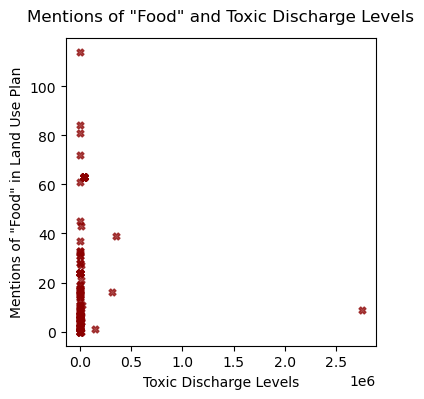

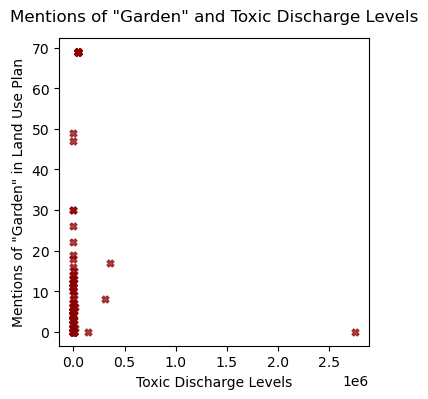

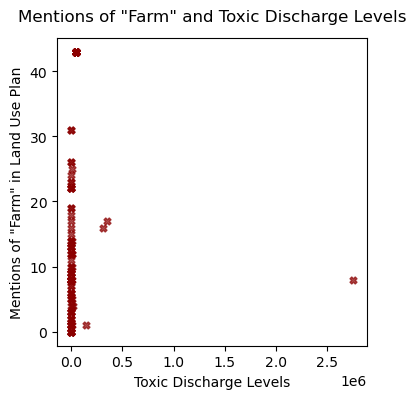

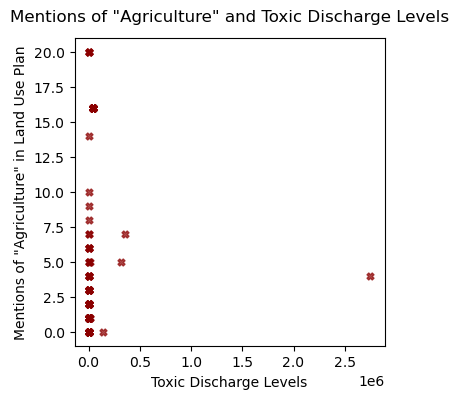

In [130]:
for key in keywords:
    fig, ax = plt.subplots(figsize= (4, 4))

    plt.scatter(LACmunikeys['Release Total'], LACmunikeys[key], marker= 'X', s= 25, c= 'darkred', alpha=0.7)
    
    plt.title('Mentions of "{}" and Toxic Discharge Levels'.format(key.title()), pad=12)
    plt.xlabel("Toxic Discharge Levels")
    plt.ylabel('Mentions of "{}" in Land Use Plan'.format(key.title()))

### (B) Proximity of Keywords: How Are Cities Talking About Food & Urban Agriculture?

This next exercise aims to make inferences about how topics like food are being talked about based on the proximity (distance of words) between keywords (e.g. "food" and "soil" or "food" and "safety"). 

For each plan, keyword set pairs will be selected and matrix math will be used to compare the distance between the individual words in those keyword set pairs. The goal is to produce 28 matrices for word pairs for each plan for the following:

    Set 1: FOOD, AGRICULTURE, GARDEN, FARM
    Set 2: safety, soil, sustainability, climate, environment, remediation, justice, public, residential
    
-- and then to identify the frequency of word pairs that are within 100 or less words of each other in each municipality/plan. This would need to be done with a cleaned wordlist instead of the raw text, which might produce approximate word count distances for unique word pairs that exclude a lot of (filler) words, but would ultimately be more meaningful than distance measured by spaces in the raw text.

The hope is that this method will allow me to identify where (which municipalities) are talking about food and community agriculture in conjunction with environmental health and safety more generally.

In [68]:
# for each plan
keywords1 = ['food', 'garden', 'farm', 'agriculture']  
keywords2 = ['soil', 'remediation', 'sustainability', 'climate', 'environment', 'safety', 'justice',
            'public', 'residential']

proxim = {}
plan_col = []

for plan in genplan:
    
    # create a wordlist for each plan
    wordlist = [word for word in word_tokenize(plan.lower()) 
                 if word not in swords]
    
    # create dictionaries for keyword set 1 for each plan
    lposdict1 = {}
    for key1 in keywords1:
        # generate topic counts to populate dictionary frame indexed to topic
        positions1 = [i for i,w in enumerate(wordlist) if w.lower() == key1]
        lposdict1[key1] = positions1

    # create dictionaries for keyword set 2 for each plan
    lposdict2 = {}
    for key2 in keywords2:
        # generate topic counts to populate dictionary frame indexed to topic
        positions2 = [i for i,w in enumerate(wordlist) if w.lower() == key2]
        lposdict2[key2] = positions2
    
    for key1, positions1 in lposdict1.items():
        for key2, positions2 in lposdict2.items():

            # create subtraction matrix for each keyword pair
            key1_key2 = abs(np.subtract(np.array(positions1), np.array(positions2)[:,None])) # with different array shapes
            # count occurences in each matrix where distance between keywords is <100 words + store in dictionary 
            proxim[key1, key2] = np.count_nonzero(key1_key2 < 100)
            # convert dictionary to dataframe series/column for each municipality
            prox = pd.DataFrame.from_dict(proxim, orient='index', columns=[plan.split(", ")[0]])
    
    # add each muni column generated to a single dataframe
    plan_col.append(prox)
    muniprox = pd.concat(plan_col, axis=1)

muniprox

,Agoura Hills,Alhambra,Arcadia,Artesia,Avalon,Azusa,Baldwin Park,Bell Gardens,Bell,Bellflower,Beverly Hills,Bradbury,Burbank,Calabasas,Camarillo,Carson,Cerritos,Claremont,Clearlake,Commerce,Compton,Cotati,Covina,Cudahy,Culver City,Diamond Bar,Downey,Duarte,El Monte,El Segundo,Filmore,Fort Bragg,Glendale,Hawaiian Gardens,Hawthorne,Healdsburg,Hermosa Beach,Hidden Hills,Huntington Park,Industry,Inglewood,Irwindale,La Canada Flintridge,La Habra Heights,La Mirada,La Puente,La Verne,Lakeport,Lancaster,Lawndale,Lomita,Long Beach,Lynwood,Malibu,Manhattan Beach,Maywood,Monrovia,Montebello,Monterey Park,Moorpark,Norwalk,Ojai,Oxnard,Palmdale,Palos Verdes,Paramount,Pasadena,Petaluma,Pico Rivera,Point Arena,Port Hueneme,Rancho Palos Verdes,Redondo Beach,Rohnert Park,Rolling Hills Estates,Rolling Hills,Rosemead,San Dimas,San Fernando,San Gabriel,San Marino,Santa Clarita,Santa Fe Springs,Santa Monica,Santa Paula,Santa Rosa,Sebastopol,Sierra Madre,Signal Hill,Simi Valley,Sonoma,South El Monte,South Gate,South Pasadena,Temple City,Thousand Oaks,Torrance,Ukiah,Ventura,Vernon,West Covina,West Hollywood,Westlake Village,Whittier,Willits,Windsor
"(food, soil)",0,1,0,2,0,1,1,0,0,0,0,0,0,0,3,6,0,0,0,0,0,2,0,3,0,0,1,1,0,0,0,0,3,0,2,0,0,0,0,0,2,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,1,1,0,4,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,5,0,1,0,0,2,0,0,0,14,1,0,0,0,1,0,0,0,0,0
"(food, remediation)",0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
"(food, sustainability)",1,0,2,5,0,0,37,0,12,0,7,0,0,1,0,2,0,0,0,0,0,1,0,1,0,31,0,0,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,1,19,0,0,0,0,0,0,0,0,7,0,0,11,0,0,0,0,0,0,0,13,0,0,5,0,0,0,2,0,0,0,1
"(food, climate)",0,6,0,0,0,1,6,0,4,14,32,3,6,0,0,23,0,2,0,0,0,0,0,1,0,19,0,0,13,0,0,0,0,0,4,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,10,1,2,10,0,0,1,1,0,0,7,0,0,2,5,0,0,0,2,0,0,0,0,2,0,0,1,10,0,0,0,0,0,0,0,3,3,0,0,0,5,2,2,0,1,0,9,0,0,3
"(food, environment)",0,2,1,8,0,12,4,1,3,4,5,0,1,2,6,16,0,3,1,0,10,19,0,0,0,11,0,0,287,0,0,0,10,1,10,0,14,0,1,0,13,0,0,1,0,0,1,3,0,1,0,22,0,0,0,5,4,2,8,5,0,0,4,2,0,0,4,1,1,5,0,11,3,1,3,0,0,1,0,0,0,2,4,7,0,2,33,0,1,0,1,11,10,3,28,0,1,5,0,1,13,0,0,0,0,3
"(food, safety)",0,12,3,0,3,1,9,0,1,10,15,4,0,1,9,20,2,0,4,0,4,24,2,0,0,16,5,1,1,0,0,0,6,0,6,1,7,0,1,0,6,0,0,0,0,0,0,2,0,3,4,7,3,0,0,0,10,3,24,21,0,3,1,2,0,0,4,0,1,1,2,6,0,1,0,1,0,1,0,3,0,3,3,2,0,0,36,3,2,4,1,69,13,9,0,5,0,5,0,0,16,6,1,0,0,1
"(food, justice)",0,13,0,0,0,0,0,0,0,0,13,0,0,0,0,7,0,0,0,0,1,0,1,3,0,35,0,0,11,0,0,0,1,0,95,0,0,0,0,0,76,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,69,0,12,9,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,1,0,55,0,0,0,0,1,6,0,0,0,0,0,0,0,0
"(food, public)",0,15,4,16,11,9,58,1,2,13,41,1,12,11,22,47,5,1,7,0,21,69,7,1,0,66,22,1,107,6,0,4,6,2,54,0,11,0,0,0,92,4,0,0,0,4,3,9,0,2,4,60,7,7,0,2,33,30,34,57,5,10,15,11,1,0,18,8,25,17,13,18,8,1,16,2,0,1,0,5,1,17,65,6,1,8,46,5,10,5,0,98,28,8,21,7,6,48,5,9,62,10,1,0,4,12
"(food, residential)",0,0,6,1,6,12,3,14,5,8,6,0,2,4,10,9,0,0,1,0,26,23,9,0,0,23,13,0,52,2,0,4,2,0,12,0,5,8,6,0,13,1,3,0,0,6,4,21,0,8,0,11,2,6,0,3,12,7,2,6,0,1,6,9,3,0,9,7,12,6,18,4,45,1,5,0,0,3,0,0,0,8,15,12,4,9,43,2,5,21,0,12,18,9,2,0,11,13,1,14,3,7,3,0,0,6
"(garden, soil)",0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,3,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0


In [69]:
# reorienting table the keyword pair frequencies can be joined to other gdfs
muniproxt = muniprox.transpose()

# naming index
muniproxt.index.name = 'City'

# saving keyword pairs table
muniproxt.to_csv("Plan_Keyword_Proximities.csv")

In [70]:
# show
muniproxt

,"(food, soil)","(food, remediation)","(food, sustainability)","(food, climate)","(food, environment)","(food, safety)","(food, justice)","(food, public)","(food, residential)","(garden, soil)","(garden, remediation)","(garden, sustainability)","(garden, climate)","(garden, environment)","(garden, safety)","(garden, justice)","(garden, public)","(garden, residential)","(farm, soil)","(farm, remediation)","(farm, sustainability)","(farm, climate)","(farm, environment)","(farm, safety)","(farm, justice)","(farm, public)","(farm, residential)","(agriculture, soil)","(agriculture, remediation)","(agriculture, sustainability)","(agriculture, climate)","(agriculture, environment)","(agriculture, safety)","(agriculture, justice)","(agriculture, public)","(agriculture, residential)"
City,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agoura Hills,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,8,0,0,0,0,0,0,0,0,0
Alhambra,1,1,0,6,2,12,13,15,0,1,0,1,3,1,0,0,8,8,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1
Arcadia,0,0,2,0,1,3,0,4,6,1,0,1,0,0,4,0,7,5,0,0,0,0,1,0,0,2,1,2,0,0,0,0,0,0,0,1
Artesia,2,0,5,0,8,0,0,16,1,0,0,0,0,0,4,0,2,0,0,0,0,0,1,0,0,2,2,0,0,0,0,1,0,0,6,11
Avalon,0,0,0,0,0,3,0,11,6,0,0,0,0,0,0,0,4,8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Hollywood,0,0,2,0,0,6,0,10,7,1,0,0,0,1,1,0,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,3,2
Westlake Village,0,0,0,9,0,1,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2
Whittier,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
# joining proximities table to the municipalities gdf
LACkeyprox = muniproxt.join(LAC, how = 'left')

In [72]:
# inspect/show
LACkeyprox.tail(4)

,"(food, soil)","(food, remediation)","(food, sustainability)","(food, climate)","(food, environment)","(food, safety)","(food, justice)","(food, public)","(food, residential)","(garden, soil)","(garden, remediation)","(garden, sustainability)","(garden, climate)","(garden, environment)","(garden, safety)","(garden, justice)","(garden, public)","(garden, residential)","(farm, soil)","(farm, remediation)","(farm, sustainability)","(farm, climate)","(farm, environment)","(farm, safety)","(farm, justice)","(farm, public)","(farm, residential)","(agriculture, soil)","(agriculture, remediation)","(agriculture, sustainability)","(agriculture, climate)","(agriculture, environment)","(agriculture, safety)","(agriculture, justice)","(agriculture, public)","(agriculture, residential)",Facilities,Release Total,UA Sites,County,Region,geometry
City,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Westlake Village,0,0,0,9,0,1,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0.0,0.0,1.0,Los Angeles,Southern California,"POLYGON ((-118.80042 34.13935, -118.79962 34.1..."
Whittier,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,79.0,12.0,Los Angeles,Southern California,"MULTIPOLYGON (((-118.06720 34.00014, -118.0671..."
Willits,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,3,NaN,NaN,NaN,NaN,NaN,None
Windsor,0,0,1,3,3,1,0,12,6,0,0,0,0,0,0,0,0,0,0,0,0,5,0,1,0,15,12,2,0,4,1,6,3,0,18,19,NaN,NaN,NaN,NaN,NaN,None


AttributeError: Line2D.set() got an unexpected keyword argument 'edgecolor'

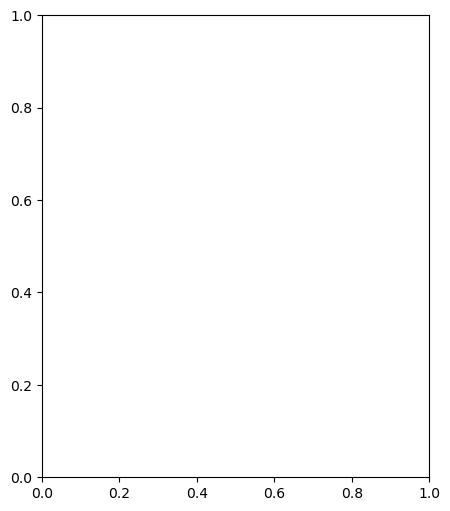

In [91]:
fig, ax = plt.subplots(figsize =(5,6))
    
# keyword
LACkeyprox.plot(ax=ax,
                column = '(food, soil)',
                edgecolor = 'darkgrey',
                linewidth = .6,
                cmap = 'Greens',
                alpha = .6,
                legend = True)
    
# customizations
ax.axis('off')
#ax.set_title('LA County Cities Discussing "{}" & "{}" Together in Their Land Use Plans'.
 #                format(pair.replace('(','').split(", ")[0].title(), pair.replace(')','').split(", ")[1].title()),
  #               fontsize=12, pad=10)
    
# basemap
ctx.add_basemap(ax, crs = 'EPSG:4326', source=ctx.providers.CartoDB.Positron)

KeyError: '(food, soil)'

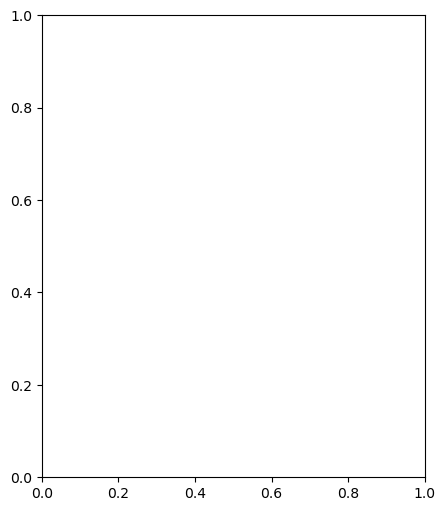

In [80]:
# loop to generate maps for each keyword pair/tuple

keypair = ['(food, soil)', '(food, climate)', '(food, remediation)', '(garden, remediation)', 
           '(garden, residential)', '(garden, justice)', '(farm, soil)', '(farm, residential)', 
           '(agriculture, soil)', '(agriculture, remediation)']

for pair in keypair:
    fig, ax = plt.subplots(figsize =(5,6))
    
    # keyword
    LACmunikeys.plot(ax=ax,
                     column = pair,
                     edgecolor = 'darkgrey',
                     linewidth = .6,
                     cmap = 'Greens',
                     alpha = .6,
                     legend = True)
    
    # customizations
    ax.axis('off')
    ax.set_title('LA County Cities Discussing "{}" & "{}" Together in Their Land Use Plans'.
                 format(pair.replace('(','').split(", ")[0].title(), pair.replace(')','').split(", ")[1].title()),
                 fontsize=12, pad=10)
    
    # basemap
    ctx.add_basemap(ax, crs = 'EPSG:4326', source=ctx.providers.CartoDB.Positron)

Now, comparing both sets of choropleth maps for (1) keyword mentions and (2) proximity of keywords related to community food production to the choropleth maps below illustrating both the density/distribution of urban agriculture sites and facilities producing toxic waste across all the municipalities in LA County... 

In [ ]:
# Toxic release choropleth map
fig, ax = plt.subplots(figsize=(10,10))

# tox release layer
LACkeyprox.plot(ax=ax,
                column= 'Facilities',
                edgecolor = 'darkgrey',
                linewidth =.5,
                cmap='Oranges',
                scheme = 'NaturalBreaks',
                alpha=.6,
                legend= True,
                legend_kwds= {'loc':'lower right', 'fontsize':'small'})

# customs
ax.axis('off')
ax.set_title("Distribution of Toxic Realease Facilities in LA County",fontsize=14, pad=10)
ax.get_legend().set_title('Facilities')

# basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

In [ ]:
# Urban ag choropleth map
fig, ax = plt.subplots(figsize=(10,10))

# urban ag layer
LACkeyprox.plot(ax=ax,
                column= 'UA Sites',
                edgecolor = 'darkgrey',
                linewidth =.5,
                cmap='Greens',
                scheme = 'NaturalBreaks',
                alpha=.5,
                legend=True,
                legend_kwds= {'loc':'lower right', 'fontsize':'small'})

# customs
ax.axis('off')
ax.set_title("Distribution of Urban Agriculture Sites in LA County",fontsize=14, pad=10)
ax.get_legend().set_title('Urban Agriculture Sites')

# basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

In [ ]:
# Toxic release choropleth map
fig, ax = plt.subplots(figsize=(10,10))

# tox release layer
LACkeyprox.plot(ax=ax,
                column= 'Release Total',
                edgecolor = 'darkgrey',
                linewidth =.5,
                cmap='Reds',
                scheme='NaturalBreaks',
                alpha=.6,
                legend= True,
                legend_kwds= {'loc':'lower right', 'fontsize':'small'})

# customs
ax.axis('off')
ax.set_title("Distribution of Toxic Release Levels in LA County",fontsize=14, pad=10)
ax.get_legend().set_title('Discharge Levels')

# basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

ANALYSIS...

### (C) Modified Topic Modeling: How Are Cities Treating Food & Urban Agriculture as Policy Priority?

The last exercise focused on identifying/verifying whether food and urban agriculture was being talked about in relation to a specific set of topics and keywords (health, safety, sustainability, climate). This is a variation on topic modeling that focuses more agnostically on finding the common words/topics around mentions of food and urban agriculture in general plans to gauge how food is talked about in municipalities more generally. 

A small subset of keywords related to community food production have been selected. The positions for all unique mentions of each keyword in each plan will be identified and word segments will be created around each of these unique keyword mentions (approximately 100 words both behind and in front of the keyword (~400 characters). 

Each of these plan segments (containing a unique mention of the keyword) will be saved as a list of segments and passed through GENSIM for topic modeling -- in the hopes the the results may provide some more general insight about the contexts in which these plans may be discussing "food" and community food production.

In [120]:
# creating a keyword subset dictionary for topic modeling purposes

# create empty dictionary to store keyword positions lists
textdictsub = {}
# create empty dictionary to store created word segments around each keyword
allsegs = {}

keyloc = ['food', 'garden', 'farm', 'agriculture', 'fruit', 'vegetable', 'animal']

for plan in genplan:
    for key in keyloc:
        # identify position for each keyword in the raw text text
        textpositionsub = [i for i in range(len(plan)) if plan.startswith(key, i)] # adapted: https://www.geeksforgeeks.org/python-all-occurrences-of-substring-in-string/#
        # save to a dictionary
        textdictsub[key, plan.split(", ")[0]] = textpositionsub

    # for each unique keyword mention in each plan, create a segment of +/- 100 words around the keyword
    for keyword, positions in textdictsub.items():
        for position in positions:
            # add row to dict for ea unique key mention and corresponding word segments
            allsegs[keyword, position] = plan[position-400:position+400]
            
        # turn dict into df: store ea segment for ea keyword in keyloc (for ea plan in genplan)
        allsegsdf = pd.DataFrame.from_dict(allsegs, orient='index', columns=['segment'])
        
#inspect/show
allsegsdf

,segment
"((food, Agoura Hills), 78416)",ood community and regional commercial centers ...
"((food, Agoura Hills), 250815)",urage the development of childcare facilities ...
"((farm, Agoura Hills), 91550)",nagement strategy that accommodates change in ...
"((farm, Agoura Hills), 92945)",ith sufficient land to accommodate the Towns g...
"((animal, Agoura Hills), 55924)",esource Parks and Recreation PR FAR Open Space...
...,...
"((animal, Windsor), 260448)",rt and advocate efforts by the Sonoma County A...
"((animal, Windsor), 277519)",l and aesthetic values As development pressure...
"((animal, Windsor), 277906)",us plant and animal species including special ...
"((animal, Windsor), 278118)",icies in this section guide the Town in the pr...


In [124]:
# converting the list of segments in the dataframe (the segment series) into a list of strings
allsegslist = allsegsdf.segment.values

# identifying more words to exclude
words_to_exclude = ['shall','area','windsor', 'plan']

# turning list of segment strings into a list of segment lists
# list of strings: ea string is a narrow word segment surrounding each unique keyword mention
planseglists = [[word for word in word_tokenize(seg.lower())
                 if word not in swords and word not in words_to_exclude
                 and len(word)>2] for seg in allsegslist]

In [122]:
print('There are {} total segments in planseglists.'.format(len(planseglists)))

There are 5609 total segments in planseglists.


Now, the list of segments for all unique keyword mentions for each keyword for each plan will be passed through GENSIM for topic modeling.

In [125]:
# generating topic model: start w/ 5 topics
dictionary = gensim.corpora.Dictionary(planseglists)
corpus = [dictionary.doc2bow(planseg) for planseg in planseglists]
# LdaMulticore uses multiple cores (thus, it runs faster); if you have problems, try replacing LdaMulticore with LdaModel
model = gensim.models.LdaMulticore(corpus, id2word=dictionary, num_topics=5)

# show topics
model.show_topics()

[(0,
  '0.027*"town" + 0.011*"development" + 0.009*"use" + 0.009*"community" + 0.008*"public" + 0.008*"land" + 0.007*"general" + 0.007*"density" + 0.007*"residential" + 0.007*"housing"'),
 (1,
  '0.019*"town" + 0.013*"development" + 0.010*"general" + 0.010*"public" + 0.010*"use" + 0.009*"areas" + 0.009*"residential" + 0.009*"pfs" + 0.008*"uses" + 0.006*"land"'),
 (2,
  '0.037*"town" + 0.017*"development" + 0.017*"general" + 0.010*"policies" + 0.008*"housing" + 0.008*"implementation" + 0.008*"policy" + 0.007*"community" + 0.007*"adopted" + 0.007*"public"'),
 (3,
  '0.033*"town" + 0.011*"use" + 0.010*"development" + 0.009*"public" + 0.009*"land" + 0.009*"residential" + 0.007*"general" + 0.006*"areas" + 0.006*"community" + 0.006*"implementation"'),
 (4,
  '0.032*"town" + 0.013*"development" + 0.009*"general" + 0.008*"residential" + 0.008*"public" + 0.008*"community" + 0.007*"implementation" + 0.007*"policies" + 0.007*"use" + 0.007*"design"')]

Now to visualize the topics most commonly discussed around mentions of food and food production.

In [126]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.027688 -0.010908       1        1  29.850472
4     -0.017780 -0.010699       2        1  22.206198
3      0.004056  0.025785       3        1  16.722446
0      0.006001  0.015263       4        1  16.000865
1      0.035411 -0.019441       5        1  15.220019, topic_info=             Term         Freq        Total Category  logprob  loglift
92            pfs  1343.000000  1343.000000  Default  30.0000  30.0000
201           far   551.000000   551.000000  Default  29.0000  29.0000
192       density   808.000000   808.000000  Default  28.0000  28.0000
194   designation   448.000000   448.000000  Default  27.0000  27.0000
98            use  2174.000000  2174.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1122          phs   147.104314  1122.826250   Topic5  -5.6033  -0.1499
12      community   156.838405  1804.099874   Topic5  -5.5393  -0.5600
39         policy   151.277837  1481.575668   Topic5  -5.5754  -0.3992
40        program   139.217218  1398.479824   Topic5  -5.6585  -0.4245
613       parking   137.149127   852.650449   Topic5  -5.6734   0.0553

[449 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
697       1  0.864396      abag
697       5  0.108049      abag
699       1  0.831504  achieves
699       2  0.083150  achieves
699       5  0.083150  achieves
...     ...       ...       ...
4299      4  0.120139   worship
1052      1  0.717581       zne
1052      2  0.153767       zne
1052      3  0.051256       zne
1052      4  0.051256       zne

[1246 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 1, 2])

### (D) Discussion: Implications & Limitations

Based on the preliminary maps and scatterplots, ...

Los Angeles City proper and Long Beach contain both the most urban agriculture sites, toxic release facilities, and highest levels of toxic discharge. However, for the distribution outcomes to be more information, need to be weighted by population totals for each municipality and land area, since the municipalities vary wildly in shape and size (Los Angeles City, in particular)

Include other demographic data, like race and ethnicity, income levels, and housing tenure.

Topic modeling exercise was intended as counterapproach to the more targeted approaches I took in identifying keyword and keyword pair frequencies. The former approach was meant to allow me to identify whether food and food production was being considered in land use planning in very specific contexts (the quality of the environments where food would be locally produced) whereas the latter approach was meant to augment this analysis by further considering -- "How might food production be considered if at all in land use plans? If food production is not being talked about in the context of soils and the environment, how is it being talked about?"

The results of the modified topic modeling process do not point to any coherent topic trends, which suggest that food production is not really considered at all in these plans. I originally thought there might be value in segmenting the topic modeling by Counties, but seeing how "general" the results are, now believe the outcome may just be the same -- that community food production is not given much consideration in local land use planning.

### (E) Future Analysis: Environmental Justice in the City -- Are Food Systems Part of the Picture?

In the future, I would also like to replicate the previous exercises exclusively on the smaller body of Environmental Justice Elements of General Plans (for those plans that contain them). In 2016, the state of California passed legislation requiring all municipalities to include environmental justice planning in their overall city planning.